In [67]:
import yfinance as yf
# from isyatirimhisse import veri_cek # opsiyonel
import pandas as pd
import numpy as np
import statsmodels.api as sm
from arch import arch_model
from scipy.optimize import minimize
from scipy.stats import norm
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from EigenLedger import portfolio_analysis, Engine
from tabulate import tabulate # opsiyonel
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # opsiyonel

In [68]:
is_gunu = 250 # İş günü 252 olarak da girilebiliyor
risksiz_faiz_orani = 0.1

In [69]:
def yfinance_veri_cek(sembol, baslangic_tarih, bitis_tarih, frekans, getiri=True, log_getiri=True):
    liste = []

    for s in sembol:
        tarihsel = yf.download(
            tickers=s,
            start=baslangic_tarih,
            end=bitis_tarih,
            interval=frekans
        )

        veriler_df_alt = pd.DataFrame(tarihsel).reset_index()
        veriler_df_alt = veriler_df_alt[['Date','Adj Close']].rename(columns={'Date':'Tarih','Adj Close':f'{s.replace(".IS","")}'})
        liste.append(veriler_df_alt)

    veriler_df = liste[0]
    for i in range(1,len(liste)):
        veriler_df = pd.merge(veriler_df, liste[i], on='Tarih', how='outer')

    if frekans == '1d':
        tarih = '2020-07-27'
        df_problem = veriler_df[veriler_df['Tarih'] < tarih]
        df_normal = veriler_df[veriler_df['Tarih'] >= tarih]

        xu_sutunlar = [xu for xu in df_problem.columns if xu.startswith('XU')]

        for xu_sutun in xu_sutunlar:
            for index, value in enumerate(df_problem[xu_sutun]):
                df_problem.at[index, xu_sutun] = value / 100

        veriler_df = pd.concat([df_problem, df_normal], ignore_index=True)

    elif frekans == '1mo':
        tarih = '2020-07-01'
        df_problem = veriler_df[veriler_df['Tarih'] < tarih]
        df_normal = veriler_df[veriler_df['Tarih'] >= tarih]

        xu_sutunlar = [xu for xu in df_problem.columns if xu.startswith('XU')]

        for xu_sutun in xu_sutunlar:
            for index, value in enumerate(df_problem[xu_sutun]):
                df_problem.at[index, xu_sutun] = value / 100

        veriler_df = pd.concat([df_problem, df_normal], ignore_index=True)

    veriler_df = veriler_df.set_index('Tarih')

    if getiri and log_getiri:
        veriler_df = veriler_df.apply(lambda x: np.log(x / x.shift(1)))
    elif getiri and not log_getiri:
        veriler_df = veriler_df.apply(lambda x: x / x.shift(1) - 1)
    elif not getiri:
        veriler_df

    veriler_df = veriler_df.reset_index()
    veriler_df = veriler_df.dropna()
    veriler_df = veriler_df.reset_index(drop=True)

    return veriler_df

In [70]:
semboller = ['THYAO.IS', 'GARAN.IS']
baslangic_tarih = '2023-01-01'
bitis_tarih = '2023-08-01'
frekans = '1mo'

"""

Bazı frekans bilgileri:
    1h: 1 saatlik,
    1d: 1 günlük,
    1wk: 1 haftalık,
    1mo: 1 aylık

"""

veriler_df = yfinance_veri_cek(
    sembol = semboller,
    baslangic_tarih = baslangic_tarih,
    bitis_tarih = bitis_tarih,
    frekans = frekans
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


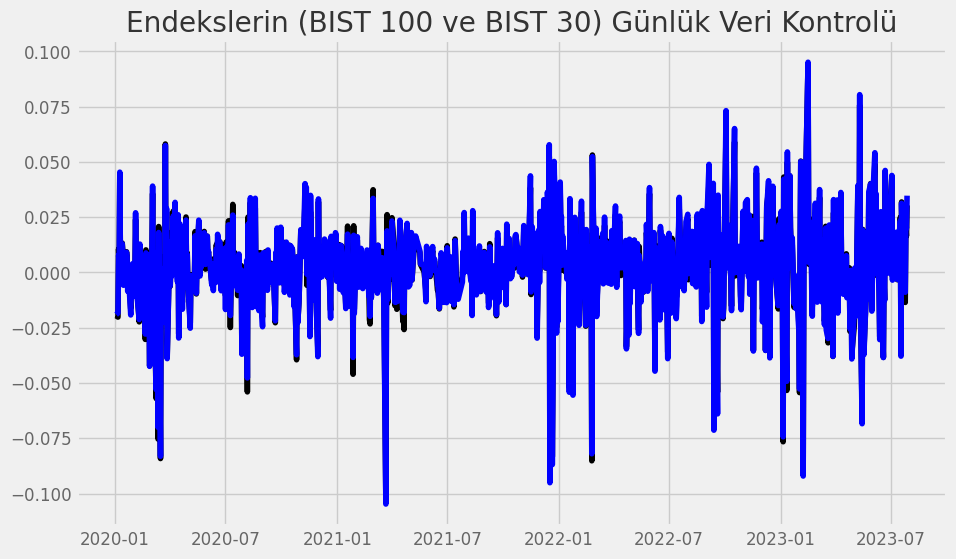

In [71]:
semboller = ['XU100.IS','XU030.IS']
baslangic_tarih = '2020-01-02'
bitis_tarih = '2023-07-29'
frekans = '1d'

veriler_df = yfinance_veri_cek(
    sembol = semboller,
    baslangic_tarih = baslangic_tarih,
    bitis_tarih = bitis_tarih,
    frekans = frekans
)
veriler_df = veriler_df.dropna()

plt.plot(
    'Tarih',
    'XU100',
    data=veriler_df,
    color='black'
)
plt.plot(
    'Tarih',
    'XU030',
    data=veriler_df,
    color='blue'
)
plt.title('Endekslerin (BIST 100 ve BIST 30) Günlük Veri Kontrolü')
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


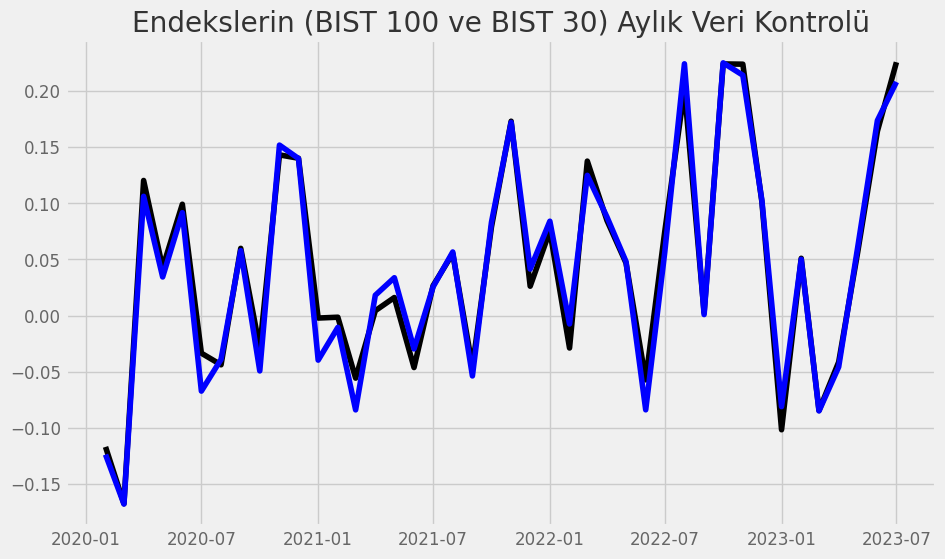

In [72]:
semboller = ['XU100.IS','XU030.IS']
baslangic_tarih = '2020-01-01'
bitis_tarih = '2023-08-01'
frekans = '1mo'

df = yfinance_veri_cek(
    sembol = semboller,
    baslangic_tarih = baslangic_tarih,
    bitis_tarih = bitis_tarih,
    frekans = frekans
)
df = df.dropna()

plt.plot(
    'Tarih',
    'XU100',
    data=df,
    color='black'
)
plt.plot(
    'Tarih',
    'XU030',
    data=df,
    color='blue'
)
plt.title('Endekslerin (BIST 100 ve BIST 30) Aylık Veri Kontrolü')
plt.show()

In [73]:
# Getiri hesaplasın ve logaritmik getiri olsun

semboller = ['XU100.IS', 'THYAO.IS']
baslangic_tarih = '2018-06-01'
bitis_tarih = '2023-08-01'
frekans = '1mo'

veriler_df = yfinance_veri_cek(
    sembol = semboller,
    baslangic_tarih = baslangic_tarih,
    bitis_tarih = bitis_tarih,
    frekans = frekans
)

veriler_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Tarih,XU100,THYAO
0,2018-07-01,0.004467,0.247022
1,2018-08-01,-0.044597,-0.059034
2,2018-09-01,0.075118,0.161843
3,2018-10-01,-0.102702,-0.312009
4,2018-11-01,0.056209,0.196379
...,...,...,...
56,2023-03-01,-0.084506,-0.192119
57,2023-04-01,-0.041360,0.075554
58,2023-05-01,0.056618,0.117957
59,2023-06-01,0.164223,0.297887


In [74]:
# Getiri hesaplasın ve basit getiri olsun

semboller = ['XU100.IS', 'THYAO.IS']
baslangic_tarih = '2018-06-01'
bitis_tarih = '2023-08-01'
frekans = '1mo'
log_getiri = False

veriler_df = yfinance_veri_cek(
    sembol = semboller,
    baslangic_tarih = baslangic_tarih,
    bitis_tarih = bitis_tarih,
    frekans = frekans,
    log_getiri = log_getiri
)

veriler_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Tarih,XU100,THYAO
0,2018-07-01,0.004477,0.280208
1,2018-08-01,-0.043617,-0.057325
2,2018-09-01,0.078012,0.175676
3,2018-10-01,-0.097604,-0.268025
4,2018-11-01,0.057819,0.216988
...,...,...,...
56,2023-03-01,-0.081034,-0.174791
57,2023-04-01,-0.040516,0.078481
58,2023-05-01,0.058252,0.125196
59,2023-06-01,0.178477,0.347010


In [75]:
sembol = ['THYAO.IS']
baslangic_tarih = '2021-12-01'
bitis_tarih = '2023-01-01'
frekans = '1mo'

veriler_df = yfinance_veri_cek(
    sembol = sembol,
    baslangic_tarih = baslangic_tarih,
    bitis_tarih = bitis_tarih,
    frekans = frekans
)

[*********************100%***********************]  1 of 1 completed


In [76]:
yillik_surekli_bilesik_getiri_toplam = (veriler_df['THYAO'].sum()) * 100
yillik_surekli_bilesik_getiri_ortalama_12 = (veriler_df['THYAO'].mean() * 12) * 100

In [77]:
print(tabulate(
    [['THYAO',yillik_surekli_bilesik_getiri_toplam,yillik_surekli_bilesik_getiri_ortalama_12]],
    headers=['Yıllık Sürekli Bileşik Getiri (Toplam), %','Yıllık Sürekli Bileşik Getiri (Çarpım, 12), %'],
    tablefmt='fancy_grid',
    stralign='center',
    numalign='center',
    floatfmt='.1f'
))

╒═══════╤═════════════════════════════════════════════╤═════════════════════════════════════════════════╕
│       │  Yıllık Sürekli Bileşik Getiri (Toplam), %  │  Yıllık Sürekli Bileşik Getiri (Çarpım, 12), %  │
╞═══════╪═════════════════════════════════════════════╪═════════════════════════════════════════════════╡
│ THYAO │                    195.1                    │                      195.1                      │
╘═══════╧═════════════════════════════════════════════╧═════════════════════════════════════════════════╛


In [78]:
# Ocak/2022 - Aralık/2022 Aylık Enflasyon Verileri
enflasyon = pd.Series([11.1,4.81,5.46,7.25,2.98,4.95,2.37,1.46,3.08,3.54,2.88,1.18]) / 100

veriler_df = pd.concat([veriler_df, enflasyon.to_frame(name='Enflasyon')], axis=1)

veriler_df

,Tarih,THYAO,Enflasyon
0,2022-01-01,0.360862,0.1110
1,2022-02-01,-0.114220,0.0481
2,2022-03-01,0.230455,0.0546
3,2022-04-01,0.246065,0.0725
4,2022-05-01,0.190128,0.0298
5,2022-06-01,-0.064138,0.0495
6,2022-07-01,0.074108,0.0237
7,2022-08-01,0.371837,0.0146
8,2022-09-01,-0.034798,0.0308
9,2022-10-01,0.361056,0.0354


In [79]:
veriler_df['ReelGetiri'] = veriler_df['THYAO'] - veriler_df['Enflasyon']
veriler_df

,Tarih,THYAO,Enflasyon,ReelGetiri
0,2022-01-01,0.360862,0.1110,0.249862
1,2022-02-01,-0.114220,0.0481,-0.162320
2,2022-03-01,0.230455,0.0546,0.175855
3,2022-04-01,0.246065,0.0725,0.173565
4,2022-05-01,0.190128,0.0298,0.160328
5,2022-06-01,-0.064138,0.0495,-0.113638
6,2022-07-01,0.074108,0.0237,0.050408
7,2022-08-01,0.371837,0.0146,0.357237
8,2022-09-01,-0.034798,0.0308,-0.065598
9,2022-10-01,0.361056,0.0354,0.325656


In [80]:
yillik_surekli_bilesik_reel_getiri = (veriler_df['ReelGetiri'].sum()) * 100
yillik_surekli_bilesik_reel_getiri

144.07185788341747

In [81]:
print(tabulate(
    [['THYAO',yillik_surekli_bilesik_getiri_toplam,yillik_surekli_bilesik_reel_getiri]],
    headers=['Yıllık Sürekli Bileşik Getiri, %','Yıllık Sürekli Bileşik Reel Getiri, %'],
    tablefmt='fancy_grid',
    stralign='center',
    numalign='center',
    floatfmt='.1f'
))

╒═══════╤════════════════════════════════════╤═════════════════════════════════════════╕
│       │  Yıllık Sürekli Bileşik Getiri, %  │  Yıllık Sürekli Bileşik Reel Getiri, %  │
╞═══════╪════════════════════════════════════╪═════════════════════════════════════════╡
│ THYAO │               195.1                │                  144.1                  │
╘═══════╧════════════════════════════════════╧═════════════════════════════════════════╛


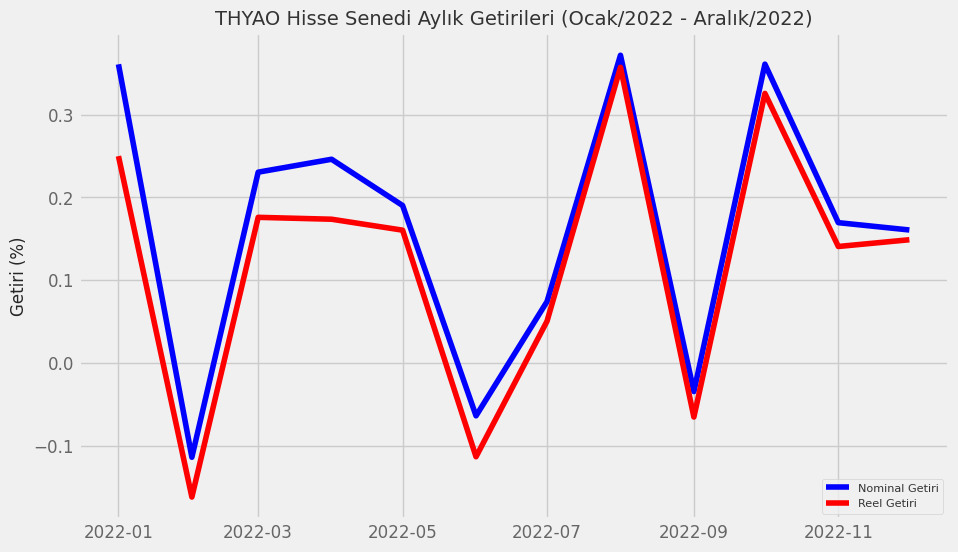

In [82]:
plt.plot(
    'Tarih',
    'THYAO',
    data=veriler_df,
    color='blue',
    label='Nominal Getiri'
)
plt.plot(
    'Tarih',
    'ReelGetiri',
    data=veriler_df,
    color='red',
    label='Reel Getiri'
)
plt.ylabel('Getiri (%)', fontsize='12')
plt.title('THYAO Hisse Senedi Aylık Getirileri (Ocak/2022 - Aralık/2022)', fontsize='14')
plt.legend(fontsize='xx-small', loc='lower right')
plt.show()

In [83]:
sembol = ['THYAO.IS']
baslangic_tarih = '2018-08-16'
bitis_tarih = '2023-07-29'
frekans = '1d'

veriler_df = yfinance_veri_cek(
    sembol = sembol,
    baslangic_tarih = baslangic_tarih,
    bitis_tarih = bitis_tarih,
    frekans = frekans
)

veriler_df

[*********************100%***********************]  1 of 1 completed


,Tarih,THYAO
0,2018-08-17,-0.022007
1,2018-08-20,0.046044
2,2018-08-21,0.000000
3,2018-08-22,0.000000
4,2018-08-23,0.000000
...,...,...
1245,2023-07-24,-0.008083
1246,2023-07-25,-0.020497
1247,2023-07-26,0.030814
1248,2023-07-27,0.019444


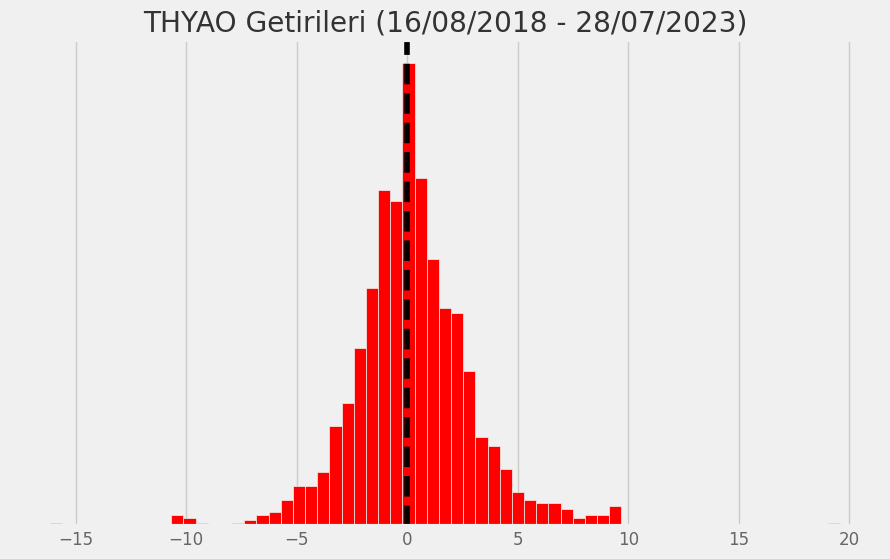

In [84]:
plt.hist(
    veriler_df['THYAO'] * 100,
    color='red',
    bins='auto'
)
plt.title('THYAO Getirileri (16/08/2018 - 28/07/2023)')
plt.yticks([])
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

In [86]:
beklenen_getiri_ortalama_gunluk = (veriler_df['THYAO'].mean()) * 100
beklenen_getiri_ortalama_gunluk

0.21688267016473478

In [88]:
beklenen_getiri_ortalama_yillik_1 = beklenen_getiri_ortalama_gunluk * is_gunu
beklenen_getiri_ortalama_yillik_2 = ((1 + beklenen_getiri_ortalama_gunluk/100)**is_gunu - 1) * 100

In [89]:
print(tabulate(
    [['THYAO',beklenen_getiri_ortalama_gunluk,beklenen_getiri_ortalama_yillik_1,beklenen_getiri_ortalama_yillik_2]],
    headers=['Beklenen Getiri (Günlük), %','Beklenen Getiri (Yıllık), %','Beklenen Getiri (Yıllık), %'],
    tablefmt='fancy_grid',
    stralign='center',
    numalign='center',
    floatfmt='.1f'
))

╒═══════╤═══════════════════════════════╤═══════════════════════════════╤═══════════════════════════════╕
│       │  Beklenen Getiri (Günlük), %  │  Beklenen Getiri (Yıllık), %  │  Beklenen Getiri (Yıllık), %  │
╞═══════╪═══════════════════════════════╪═══════════════════════════════╪═══════════════════════════════╡
│ THYAO │              0.2              │             54.2              │             71.9              │
╘═══════╧═══════════════════════════════╧═══════════════════════════════╧═══════════════════════════════╛


## 4.6.2. Senaryoya Bağlı Ağırlıklandırılmış Olasılıklar
